# Vegetation in north-east LA

The goal of this script is to create a map showing all of the green space in north-east LA


*Resources*
* [GEE python API](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api)

In [237]:
download_data = False

import pprint
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.mask import mask 
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import sklearn

### Set paths to data

In [11]:
path_to_sr_data = "data/l9_sr_data_ne_la/l9-sr-07312023-215217.tif"
path_to_training_polygons = "data/training_polygons/"

### Authenticate to Earth Engine

In [3]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1Adeu5BU7c7y355EE7X72iNRQgnoaAv_u984mjH6F8ZQXkkA58lJj-6urbpY

Successfully saved authorization token.


### Functions

In [4]:
def addQualityBands(image,nir_band='SR_B5',red_band='SR_B4'):
    
    '''
    Adds NDVI as a band to an image

    image: earth engine image
    nir_band: the name of the nir band (str)
    red_band: the name of the red band (str)
    
    returns: earth engine image with NDVI band added as "nd"
    '''   
    new_image = image.addBands(image.normalizedDifference([nir_band, red_band])).\
    addBands(image.metadata('system:time_start'))
    return new_image


def applyL9ScaleFactors(image):

    '''Scales Landsat 9 Surface Reflectance and Surface Temp Imagery'''
    
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    
    return image.addBands(opticalBands, None, True).\
                 addBands(thermalBands, None, True)

def crop_raster_to_poly(raster,poly):
    '''
    Crop a raster to the extent of a polygon and extract values into an numpy array.
    
    Inputs: Raster (DatasetReader Object e.g. from rasterio), shapely polygon (shapely.geometry.polygon.Polygon)
    
    Outputs: Numpy array with shape (n bands, pixel height, pixel width)
    '''
    
    geo = poly.__geo_interface__
    out_image, out_transform = mask(raster, [geo], crop=True)
    return out_image
    
def spatial_array_to_records(sa):
    '''
    Reshape a spatial array from shape (n bands,x,y) to array of shape(pixel, n_bands)
    
    Input: numpy array with shape (n_bands,x,y)
    '''
    reshaped_image = sa.reshape(sa.shape[0], sa.shape[1] * sa.shape[2]).T
    return reshaped_image

### Define Study Area

In [5]:
#This polygon contains north-east LA
la = ee.Geometry.Polygon(
        [[[-118.35161117644401, 34.24077194860868],#upper left
          [-118.35161117644401, 34.02365585890141],#lower left
          [-118.00348190398307, 34.02365585890141],#lower right
          [-118.00348190398307, 34.24077194860868]]], None, False);#upper right

### Get Landsat 9 data in north-east LA

In [6]:
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").\
     filterBounds(la).\ #geographic filter
     filterDate('2022-02-01','2022-06-01').\ #filter to season of vegetation growth
     map(applyL9ScaleFactors).\ #scale the surface reflectance data
     map(addQualityBands).\ #add NDVI to the collection
     qualityMosaic('nd').\ #create a quality mosaic maximizing NDVI
     select(['SR_B.']) #select all surface reflectance bands
 
#pprint.pprint(l9)

### Define the visualization parameters

True color shows a true color image in RGB

False color composite put the NIR surface reflectance into the red channel so that areas of active photosynthesis appear red.

In [7]:
# True color viz params
vizParams_true_color = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
  'dimensions': 512, 
  'region': la,
}

# False color composite
vizParams_false_color = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
  'min': 0.0,
  'max': 0.3,
  'dimensions': 512, 
  'region': la,
}

### View surface reflectance in north-east LA

In [8]:
from IPython.display import Image

# Create a URL to the styled image
url = l9.getThumbUrl(vizParams_false_color)
#print(url)

# Display the thumbnail
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/72201e4e1f7bd75937020032e79b77fb-4a95024d3cfa0bfa6d1e09db95b9984a:getPixels

Please wait while the thumbnail loads, it may take a moment...


### Download Landsat 9 surface reflectance data

In [9]:
if download_data == True:
    from datetime import datetime
    now = datetime.now() # datetime object containing current date and time
    print("Downloading data at", now)
    dt_string = now.strftime("%m%d%Y-%H%M%S")
    file_name = 'l9-sr-' + dt_string
    print("File name:",file_name)
    task = ee.batch.Export.image.toDrive(image=l9,
                                         description='l9-sr',
                                         scale=30,
                                         region=la,
                                         folder="l9_sr_data_ne_la",
                                         fileNamePrefix=file_name,
                                         crs='EPSG:4326',
                                         fileFormat='GeoTIFF')
    task.start()
    #task.status()

### Import and view attributes of the surface reflectance data

In [123]:
#Import raster data and print some information
sr_data = rasterio.open(path_to_sr_data)
print("Number of bands:",sr_data.count)
print("\nData types:")
print({i: dtype for i, dtype in zip(sr_data.indexes, sr_data.dtypes)})
print('\n')
print(sr_data.bounds)
print('\n')
print(sr_data.transform)
print('\n')
print(sr_data.crs)

Number of bands: 7

Data types:
{1: 'float64', 2: 'float64', 3: 'float64', 4: 'float64', 5: 'float64', 6: 'float64', 7: 'float64'}


BoundingBox(left=-118.3517810413492, bottom=34.02342189144165, right=-118.00332454263923, top=34.24090402172698)


| 0.00, 0.00,-118.35|
| 0.00,-0.00, 34.24|
| 0.00, 0.00, 1.00|


EPSG:4326


In [125]:
# Read all bands
sr_array = sr_data.read()

# Calculate statistics for each band
stats = []
for band in sr_array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
stats

[{'min': -0.199725,
  'mean': 0.05757064716024039,
  'median': 0.05217499999999997,
  'max': 0.98943},
 {'min': -0.19912000000000002,
  'mean': 0.06670758027928479,
  'median': 0.060425000000000006,
  'max': 1.0018600000000002},
 {'min': -0.0814475,
  'mean': 0.0908528512071961,
  'median': 0.08514749999999999,
  'max': 0.9737825},
 {'min': 7.499999999993623e-06,
  'mean': 0.09414803314434503,
  'median': 0.0875125,
  'max': 1.004555},
 {'min': 0.0003650000000000042,
  'mean': 0.21420123990010073,
  'median': 0.21439750000000002,
  'max': 1.4482400000000002},
 {'min': -0.002714999999999995,
  'mean': 0.16585749507643377,
  'median': 0.16536499999999998,
  'max': 1.5999850000000002},
 {'min': 0.0012725000000000097,
  'mean': 0.12627333315843292,
  'median': 0.1257375,
  'max': 1.5999850000000002}]

### Import and reproject the training polygons

In [49]:
#import training polygons and reproject to EPSG 4326
urban_cover = gpd.read_file(os.path.join(path_to_training_polygons,"urban_ne_la","urban_NE_LA.shp"))
urban_cover = urban_cover.to_crs("EPSG:4326")

veg_cover = gpd.read_file(os.path.join(path_to_training_polygons,"vegetation_ne_la","vegetation_NE_LA.shp"))
veg_cover = veg_cover.to_crs("EPSG:4326")

In [110]:
veg_cover.area

/tmp/ipykernel_11226/568653549.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  veg_cover.area


0     0.000002
1     0.000003
2     0.000004
3     0.000002
4     0.000007
5     0.000007
6     0.000003
7     0.000004
8     0.000019
9     0.000020
10    0.000017
11    0.000021
12    0.000025
13    0.000011
14    0.000021
15    0.000014
16    0.000008
17    0.000569
dtype: float64

### Visualize the training polygons

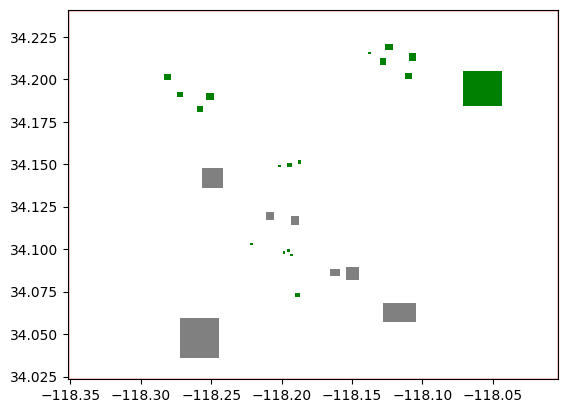

In [106]:
#define the bounds of our geotiff
bounds = sr_data.bounds

fig, ax = plt.subplots()

# Create a Rectangle patch using bounding box coordinates from the geotiff
rect = Rectangle((bounds.left, bounds.bottom), bounds.right - bounds.left, bounds.top - bounds.bottom,
                 linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Set plot limits to fit the bounding box
ax.set_xlim(bounds.left, bounds.right)
ax.set_ylim(bounds.bottom, bounds.top)

veg_cover.plot(ax = ax, color = "green")
urban_cover.plot(ax = ax, color = "gray")
plt.show()

### Extract surface reflectance data from geotiff to numpy arrays

In [208]:
# Get the data in vegetated training polygons
X_veg = np.array([]).reshape(0,7)

for i in range(len(veg_cover)):
    tmp = spatial_array_to_records((crop_raster_to_poly(sr_data,veg_cover.iloc[i].geometry)))
    X_veg = np.concatenate((X_veg,tmp))
    
# Get the data in urban training polygons
X_urb = np.array([]).reshape(0,7)

for i in range(len(urban_cover)):
    tmp = spatial_array_to_records((crop_raster_to_poly(sr_data,urban_cover.iloc[i].geometry)))
    X_urb = np.concatenate((X_urb,tmp))

### Clean and label the data

 Here we convert the data to a dataframe and remove pixels with zero or negative values for reflectance.
 We remove these pixels as a quality control because negative or zero surface reflectance
 indicates spurious or missing data. We also remove pixels with reflectance values > 1 for the same reason.

In [234]:
def remove_spurious_reflectance(df):
    return df.loc[(df > 0.00001).all(axis=1) & (df < 1.0).all(axis=1)]

# Add labels to the vegetation cover data
veg = pd.DataFrame(data = X_veg, columns=band_names)
veg = remove_spurious_reflectance(veg)
veg['label'] = True


# Add labels to the urban cover data
urb = pd.DataFrame(data = X_urb, columns=band_names)
urb = remove_spurious_reflectance(urb)
urb['label'] = False

df = pd.concat([veg,urb])

### Explore data

We have more urban labels than vegetation labels, so the data area skewed

In [235]:
print(df['label'].value_counts()) #check evenness of labels
print('\n')
print(df.info())
print('\n')
print(df.describe())

label
False    16661
True      9698
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Index: 26359 entries, 0 to 17556
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ub      26359 non-null  float64
 1   b       26359 non-null  float64
 2   g       26359 non-null  float64
 3   r       26359 non-null  float64
 4   nir     26359 non-null  float64
 5   swir1   26359 non-null  float64
 6   swir2   26359 non-null  float64
 7   label   26359 non-null  bool   
dtypes: bool(1), float64(7)
memory usage: 1.6 MB
None


                 ub             b             g             r           nir  \
count  26359.000000  26359.000000  26359.000000  26359.000000  26359.000000   
mean       0.067207      0.077903      0.099428      0.104948      0.202860   
std        0.055741      0.061651      0.065901      0.074601      0.072065   
min        0.000062      0.000585      0.002895      0.000035      0.001217   
25%        0

### Histogram

Most bands have tail-heavy distributions

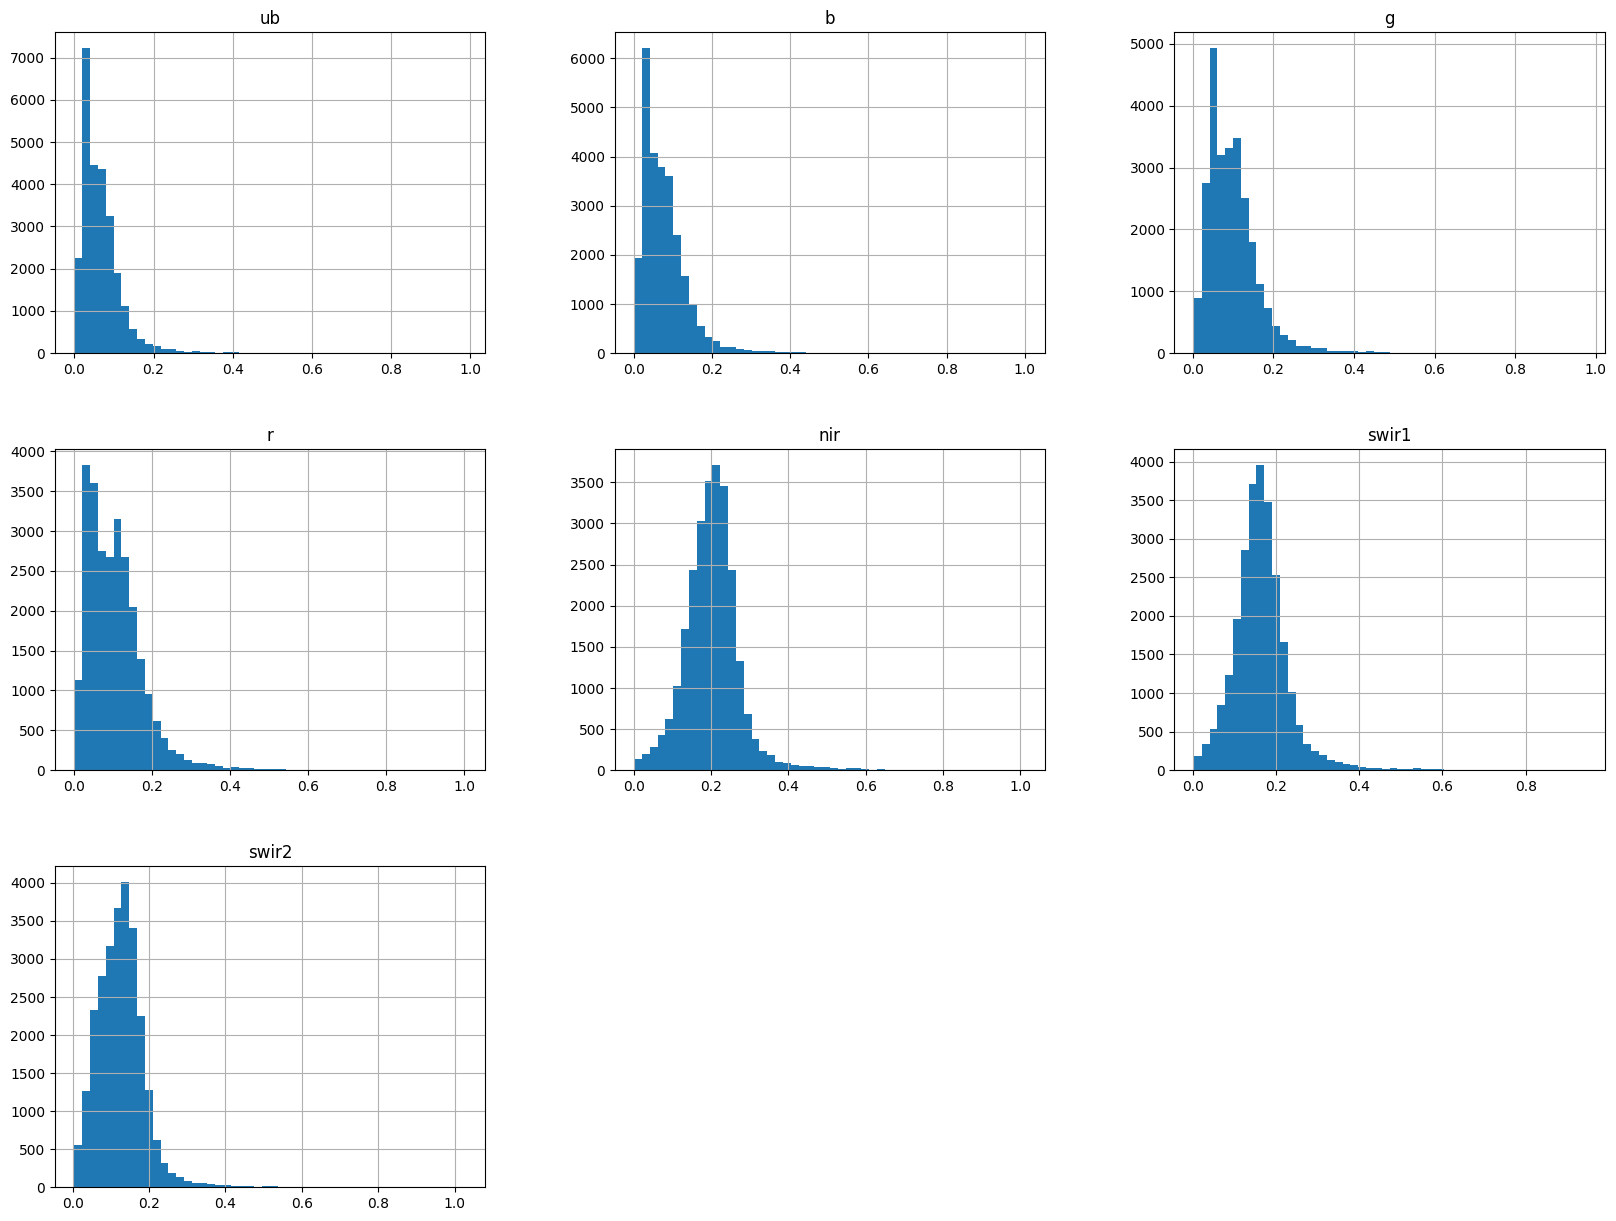

In [233]:
df.hist(bins=50, figsize=(20,15))
plt.show()

### Shuffle and split the data into training and test sets while maintaining the same ratio of veg to urban in both sets

In [254]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size =0.1, random_state = 42)

for train_index, test_index in split.split(df, df['label']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

### Separate the training data and training labels

In [259]:
train_X = train_set.drop("label", axis = 1)
train_y = train_set["label"].copy()

### Set up a data transformation pipeline to prepare the data for machine learning

In [275]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


class addNDVI(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        X["ndvi"] = (X['nir'] - X['r']) / (X['nir'] + X['r'])
        return X
    
transformation_pipeline = Pipeline([
        ('add_ndvi', addNDVI()),
        ('std_scaler', StandardScaler()),
    ])

#apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)

### Naive classifier

Use this to compare to other models

In [283]:
from sklearn.base import BaseEstimator
class AlwaysUrban(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        
        #always predicts false (0)
        return np.zeros((len(X), 1), dtype=bool)

### Train and test a Decision Tree

In [288]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Naive classifier
always_urban = AlwaysUrban()

# decision tree classifier
tree = DecisionTreeClassifier()

# test naive classifier
naive_scores = cross_val_score(always_urban, X, train_y, cv= 10, scoring="accuracy")
print("Naive:",scores)

# test regression tree
tree_scores = cross_val_score(tree, X, train_y, cv= 10, scoring="accuracy")
print("Decision Tree:",tree_scores)


#Test the linear regression model
#some_data = train_X.iloc[:5]
#some_labels = train_y.iloc[:5]

#some_prepared_data = transformation_pipeline.fit_transform(some_data)

#print("Predictions",lin_reg.predict(some_prepared_data))
#print("Labels",list(some_labels))

Naive: [0.62789718 0.63716814 0.61862621 0.64460371 0.63279933 0.63617201
 0.62984823 0.6193086  0.63111298 0.64333895]
Decision Tree: [0.98482933 0.98525074 0.98820059 0.98650927 0.98524452 0.98397976
 0.98355818 0.98524452 0.98650927 0.98397976]


### Make predictions with the decision tree

In [290]:
some_data = train_X.iloc[:5]
some_labels = train_y.iloc[:5]
some_prepared_data = transformation_pipeline.fit_transform(some_data)
tree.fit(X,train_y)

print("Predictions",tree.predict(some_prepared_data))
print("Labels",list(some_labels))

Predictions [False  True False False  True]
Labels [False, True, False, False, True]


/tmp/ipykernel_11226/1094695361.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["ndvi"] = (X['nir'] - X['r']) / (X['nir'] + X['r'])


### Train and test a random forest

In [291]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest_scores = cross_val_score(forest,X,train_y,cv=10,scoring="accuracy")

print(forest_scores)

[0.99115044 0.98651496 0.99115044 0.99367622 0.98988196 0.99072513
 0.9915683  0.9915683  0.9915683  0.99241147]


Random forest performs better than the decision tree.

### Optimize the parameters of the random forest using grid search

### pick up here with training the model on the full training data (assuming cross val doesn't do this) and then looking into its attributes (hyper-parameters) and then using grid search to find more optimal parameters

In [58]:
#returns a dict with the geo info. this could be useful for masking the raster
#a = veg_cover.__geo_interface__
#pprint.pprint(a)

In [ ]:
# labels = np.zeros(raster.shape, dtype=np.uint8)
# shapefile = shapefile.to_crs(raster.crs.data)
# for _, row in shapefile.iterrows():
#     image = features.rasterize([(row.geometry, row.label)], out_shape=raster.shape, transform=raster.transform, fill=0, all_touched=True, dtype=np.uint8)
#     labels = np.maximum(labels, image)
# combined = np.stack((raster.read(1), labels))